# Notes

This notebook reproduces the results for the ablation studies for
- varying numbers of optimization iterations: see Figure 4 (middle) and Figure A2
- varying sizes of the retrieval database; see Figure 4 (left) and Figure A3

In [20]:
%%capture
import os
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.QED import qed
import pandas as pd

import sys
project_home = '/mnt/retmol'
sys.path.insert(1, project_home + '/inference/utils')
from properties import *

data_attr = pd.read_csv(os.path.join(project_home, 
                        'data/gsk3jnk3/dual_gsk3_jnk3/actives.txt'), header=None).rename(columns={0:'smiles'})
true_mols = [Chem.MolFromSmiles(s) for s in data_attr.smiles.tolist()]
true_mols = [x for x in true_mols if x is not None]
true_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 3, 2048) for x in true_mols]
trues = set(data_attr.smiles.tolist())

In [21]:
%%capture
# scoring functions
attr='gsk3,jnk3,qed,sa'
scoring_fns = {}
thresholds = {}
if 'gsk3' in attr:
    scoring_fns['gsk3'] = gsk3_model(os.path.join(project_home))
    thresholds['gsk3'] = 0.5
if 'jnk3' in attr:
    scoring_fns['jnk3'] = jnk3_model(os.path.join(project_home))
    thresholds['jnk3'] = 0.5
if 'qed' in attr:
    scoring_fns['qed'] = qed_func()
    thresholds['qed'] = 0.6
if 'sa' in attr:
    scoring_fns['sa'] = sa_func()
    thresholds['sa'] = -4

# number of optimization iterations vs. success rate, novelty, and diversity

In [17]:
res_path = 'results_reproduce/ablations/num_opt_itrs'
file = 'ckpt50000_gsk3-jnk3-qed-sa_retrievals10_repeats80_trials1_ngenperitr1_random_batch_jitter-std1-max-mol-len-200_bs-500_ret-chembl-4attr_retmode-per-itr-faiss-megamolbart_ngens-6300-trajectory-differentSeedPerItr.csv'

res = pd.read_csv(os.path.join(project_home, res_path, file))

res = res.iloc[list(range(3700)),:]

successes_list = []
novelty_list = []
diversity_list = []

for itr in [10,20,30,40,50,60,70,80]:
    n_choose = itr
    
    # get the saved logs
    gen_smiles_all = [eval(res.iloc[row].gen_smiles_all)[0:n_choose] for row in range(len(res))]
    gsk3_all = [eval(res.iloc[row].gsk3)[0:n_choose] for row in range(len(res))]
    jnk3_all = [eval(res.iloc[row].jnk3)[0:n_choose] for row in range(len(res))]
    qed_all = [eval(res.iloc[row].qed)[0:n_choose] for row in range(len(res))]
    sa_all = [eval(res.iloc[row].sa)[0:n_choose] for row in range(len(res))]
    
    # get all success molecules
    success_smiles_list = []
    n_success = 0
    for idx in range(len(gen_smiles_all)):
        smiles_list = gen_smiles_all[idx]
        gsk3 = gsk3_all[idx]
        jnk3 = jnk3_all[idx]
        qed = qed_all[idx]
        sa = sa_all[idx]
        successes = [i for i in range(len(smiles_list)) if gsk3[i] >= 0.5 and jnk3[i] >= 0.5 and qed[i] > 0.6 and sa[i] < 4]
        success_list = [] if len(successes) == 0 else [smiles_list[i] for i in successes]
        success_smiles_list.append(success_list)
        if len(successes) > 0:
            n_success += 1
            
    success = n_success / len(gen_smiles_all)
    all_smiles = [item for sublist in success_smiles_list for item in sublist]
    successes_list.append(success)
    
    ## novelty 
    selected_preds = []
    selected_pred_fps = []
    fraction_similar = 0
    for success_smiles in [item for item in success_smiles_list if len(item) > 0]:
        # convert to mol and fingerprints
        pred_mols = [Chem.MolFromSmiles(s) for s in success_smiles]
        pred_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 3, 2048) for x in pred_mols]
        assert(len(success_smiles) == len(pred_fps))
        # select the lowest sim molecule from all success
        sims_list = []
        for i in range(len(pred_fps)):
            sims = DataStructs.BulkTanimotoSimilarity(pred_fps[i], true_fps)
            sims_list.append(max(sims))
        lowest_sims = min(sims_list)
        lowest_sims_idx = sims_list.index(lowest_sims)

        # record selected mol
        selected_preds.append(success_smiles[lowest_sims_idx])
        selected_pred_fps.append(pred_fps[lowest_sims_idx])
        # compute similarity and add to record
        if lowest_sims >= 0.4:
            fraction_similar += 1

    novelty = 1 - fraction_similar / len(selected_pred_fps)
    novelty_list.append(novelty)
    
    ## diversity
    similarity = 0
    for i in range(len(selected_pred_fps)):
        sims = DataStructs.BulkTanimotoSimilarity(selected_pred_fps[i], selected_pred_fps[:i])
        similarity += sum(sims)
    n = len(selected_pred_fps) 
    n_pairs = n * (n - 1) / 2
    diversity = 1 - similarity / n_pairs
    diversity_list.append(diversity)
    
    print('itr={}, success={:.4f}, novelty={:.4f}, diversity={:.4f}'.format(itr, success, novelty, diversity))

itr=10, success=0.3732, novelty=0.5054, diversity=0.7121
itr=20, success=0.6322, novelty=0.5909, diversity=0.7264
itr=30, success=0.7819, novelty=0.6443, diversity=0.7313
itr=40, success=0.8614, novelty=0.7107, diversity=0.7333
itr=50, success=0.9095, novelty=0.7620, diversity=0.7336
itr=60, success=0.9368, novelty=0.8027, diversity=0.7332
itr=70, success=0.9568, novelty=0.8359, diversity=0.7320
itr=80, success=0.9692, novelty=0.8622, diversity=0.7321


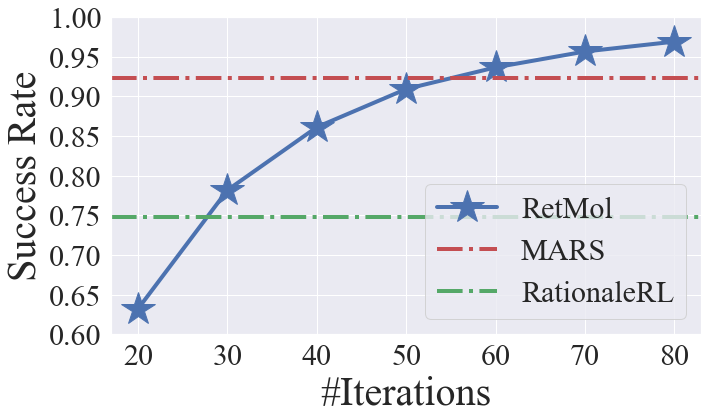

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plot = plt.plot(successes_list[1:9], marker='*', markersize=35, label='RetMol', linewidth=4)
xticks = plt.xticks(range(7), labels=[str(i) for i in list(range(20,90,10))])
xlab = plt.xlabel('#Iterations', fontsize=40)
ylab = plt.ylabel('Success Rate', fontsize=40)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)

l1 = plt.axhline(y = 0.923, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.748, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30)

# ylim = plt.ylim([0.33,0.96])
ylim = plt.ylim([0.6, 1])

# save plot
# plt.savefig('task3_ablation_numItr_successRate_80.pdf', bbox_inches='tight')

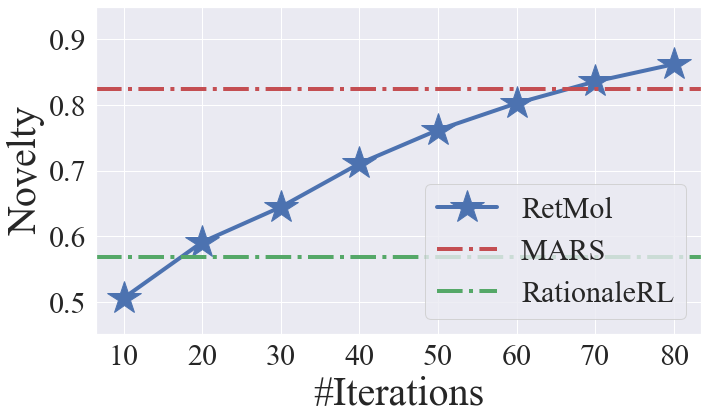

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plot = plt.plot(novelty_list[:8], marker='*', markersize=35, label='RetMol', linewidth=4)
xticks = plt.xticks(range(8), labels=[str(i) for i in list(range(10,90,10))])
xlab = plt.xlabel('#Iterations', fontsize=40)
ylab = plt.ylabel('Novelty', fontsize=40)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)

l1 = plt.axhline(y = 0.824, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.568, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30, loc='lower right')

ylim = plt.ylim([0.45,0.95])

# save plot
# plt.savefig('task3_ablation_numItr_novelty_80.pdf', bbox_inches='tight')

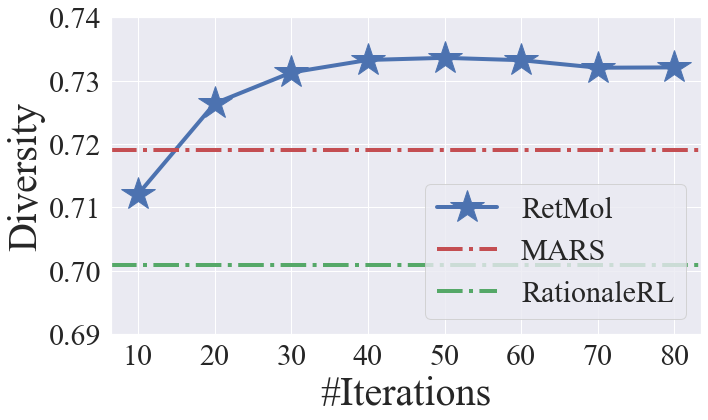

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plot = plt.plot(diversity_list[:8], marker='*', markersize=35, linewidth=4, label='RetMol')
xticks = plt.xticks(range(8), labels=[str(i) for i in list(range(10,90,10))])
xlab = plt.xlabel('#Iterations', fontsize=40)
ylab = plt.ylabel('Diversity', fontsize=40)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)

l1 = plt.axhline(y = 0.719, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.701, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30, loc='lower right')
ylim = plt.ylim([0.69,0.74])

# save plot
# plt.savefig('task3_ablation_numItr_diversity_80.pdf', bbox_inches='tight')

# size of retrieval set vs. performance (success, novelty, diversity)

In [19]:
# evaluation for trajectory
res_path = 'results_reproduce/ablations/ret_size'

successes_list = []
novelty_list = []
diversity_list = []
successes_list_std = []
novelty_list_std = []
diversity_list_std = []
itr = 80

for sub in [50,100,150,200,250,300,350,400,450,500,550,600,650,700]:
    
    tmp_success = []
    tmp_novelty = []
    tmp_diversity = []
    
    for seed in [1,2,3]:
        file = 'ckpt50000_gsk3-jnk3-qed-sa_retrievals10_repeats80_trials1_ngenperitr1_random_batch_jitter-std1-max-mol-len-200_bs-500_ret-chembl-4attr-randsub{}_retmode-per-itr-faiss-megamolbart_ngens-6300-trajectory-seed{}.csv'.format(sub, seed)
        res = pd.read_csv(os.path.join(project_home, res_path, file))
        
        n_choose = itr

        # get the saved logs
        gen_smiles_all = [eval(res.iloc[row].gen_smiles_all)[0:n_choose] for row in range(len(res))]
        gsk3_all = [eval(res.iloc[row].gsk3)[0:n_choose] for row in range(len(res))]
        jnk3_all = [eval(res.iloc[row].jnk3)[0:n_choose] for row in range(len(res))]
        qed_all = [eval(res.iloc[row].qed)[0:n_choose] for row in range(len(res))]
        sa_all = [eval(res.iloc[row].sa)[0:n_choose] for row in range(len(res))]

        # get all success molecules
        success_smiles_list = []
        n_success = 0
        for idx in range(len(gen_smiles_all)):
            smiles_list = gen_smiles_all[idx]
            gsk3 = gsk3_all[idx]
            jnk3 = jnk3_all[idx]
            qed = qed_all[idx]
            sa = sa_all[idx]
            successes = [i for i in range(len(smiles_list)) if gsk3[i] >= 0.5 and jnk3[i] >= 0.5 and qed[i] > 0.6 and sa[i] < 4]
            success_list = [] if len(successes) == 0 else [smiles_list[i] for i in successes]
            success_smiles_list.append(success_list)
            if len(successes) > 0:
                n_success += 1

        success = n_success / len(gen_smiles_all)
        all_smiles = [item for sublist in success_smiles_list for item in sublist]
        tmp_success.append(success)

        ## novelty 
        selected_preds = []
        best_idx = []
        selected_pred_fps = []
        fraction_similar = 0
        for success_smiles in [item for item in success_smiles_list if len(item) > 0]:
            # convert to mol and fingerprints
            pred_mols = [Chem.MolFromSmiles(s) for s in success_smiles]
            pred_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 3, 2048) for x in pred_mols]
            assert(len(success_smiles) == len(pred_fps))
            # select the lowest sim molecule from all success
            sims_list = []
            for i in range(len(pred_fps)):
                sims = DataStructs.BulkTanimotoSimilarity(pred_fps[i], true_fps)
                sims_list.append(max(sims))
            lowest_sims = min(sims_list)
            lowest_sims_idx = sims_list.index(lowest_sims)

            # record selected mol
            best_idx.append(lowest_sims_idx)
            selected_preds.append(success_smiles[lowest_sims_idx])
            selected_pred_fps.append(pred_fps[lowest_sims_idx])
            if lowest_sims >= 0.4:
                fraction_similar += 1

        novelty = 1 - fraction_similar / len(selected_pred_fps)
        tmp_novelty.append(novelty)

        ## diversity
        similarity = 0
        for i in range(len(selected_pred_fps)):
            sims = DataStructs.BulkTanimotoSimilarity(selected_pred_fps[i], selected_pred_fps[:i])
            similarity += sum(sims)
        n = len(selected_pred_fps) 
        n_pairs = n * (n - 1) / 2
        diversity = 1 - similarity / n_pairs
        tmp_diversity.append(diversity)
            
    successes_list.append(np.array(tmp_success).mean().item())
    successes_list_std.append(np.array(tmp_success).std().item())
    novelty_list.append(np.array(tmp_novelty).mean().item())
    novelty_list_std.append(np.array(tmp_novelty).std().item())
    diversity_list.append(np.array(tmp_diversity).mean().item())
    diversity_list_std.append(np.array(tmp_diversity).std().item())
    
    print('sub={}, success={:.4f}, novelty={:.4f}, diversity={:.4f}'.format(sub, successes_list[-1], novelty_list[-1], diversity_list[-1]))

sub=50, success=0.9178, novelty=0.6932, diversity=0.6628
sub=100, success=0.9531, novelty=0.7624, diversity=0.6672
sub=150, success=0.9516, novelty=0.8101, diversity=0.6604
sub=200, success=0.9667, novelty=0.8280, diversity=0.6632
sub=250, success=0.9809, novelty=0.8825, diversity=0.6774
sub=300, success=0.9839, novelty=0.8730, diversity=0.6953
sub=350, success=0.9820, novelty=0.8659, diversity=0.7070
sub=400, success=0.9845, novelty=0.8737, diversity=0.7024
sub=450, success=0.9867, novelty=0.8832, diversity=0.7084
sub=500, success=0.9826, novelty=0.8808, diversity=0.7145
sub=550, success=0.9804, novelty=0.8608, diversity=0.7150
sub=600, success=0.9801, novelty=0.8514, diversity=0.7206
sub=650, success=0.9786, novelty=0.8763, diversity=0.7242
sub=700, success=0.9711, novelty=0.8651, diversity=0.7289


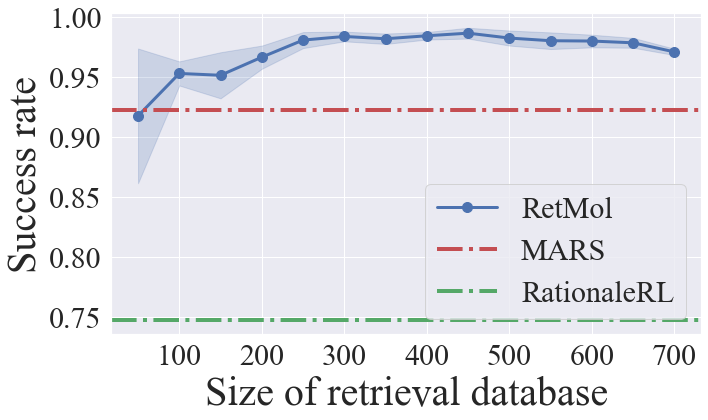

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plt.plot(list(range(50, 750, 50)), successes_list, 'b-', label='RetMol', marker='.', markersize=20, linewidth=3)
plt.fill_between(list(range(50, 750, 50)), 
                 np.array(successes_list) - np.array(successes_list_std), 
                 np.array(successes_list) + np.array(successes_list_std), color='b', alpha=0.2)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)
ylab = plt.ylabel('Success rate', fontsize=40)
xlab = plt.xlabel('Size of retrieval database', fontsize=40)

l1 = plt.axhline(y = 0.923, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.748, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30, loc='lower right')

# save plot
# plt.savefig('task3_ablation_numRetDatabase_successRate_80.pdf', bbox_inches='tight')

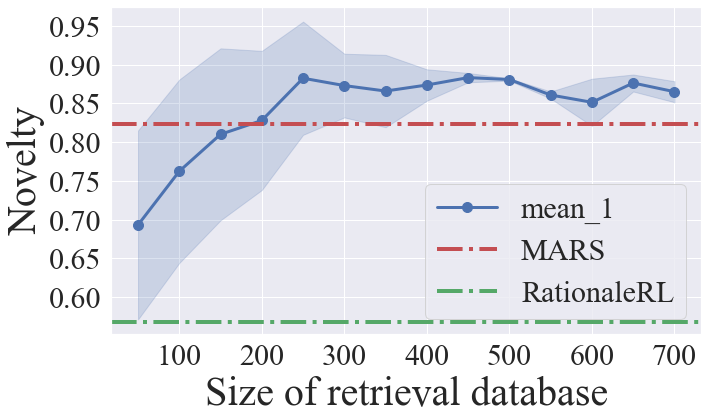

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plt.plot(list(range(50, 750, 50)), novelty_list, 'b-', label='mean_1', marker='.', markersize=20, linewidth=3)
plt.fill_between(list(range(50, 750, 50)), 
                 np.array(novelty_list) - np.array(novelty_list_std), 
                 np.array(novelty_list) + np.array(novelty_list_std), color='b', alpha=0.2)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)
ylab = plt.ylabel('Novelty', fontsize=40)
xlab = plt.xlabel('Size of retrieval database', fontsize=40)

l1 = plt.axhline(y = 0.824, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.568, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30, loc='lower right')

# save plot
# plt.savefig('task3_ablation_numRetDatabase_novelty_80.pdf', bbox_inches='tight')

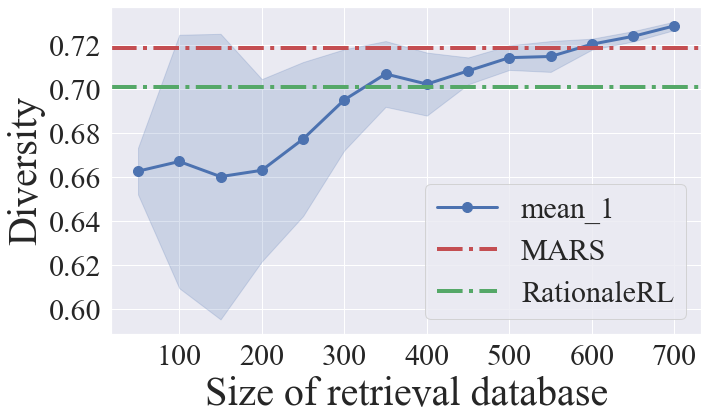

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

plt.plot(list(range(50, 750, 50)), diversity_list, 'b-', label='mean_1', marker='.', markersize=20, linewidth=3)
plt.fill_between(list(range(50, 750, 50)), 
                 np.array(diversity_list) - np.array(diversity_list_std), 
                 np.array(diversity_list) + np.array(diversity_list_std), color='b', alpha=0.2)
xtick = plt.xticks(fontsize=30)
ytick = plt.yticks(fontsize=30)
ylab = plt.ylabel('Diversity', fontsize=40)
xlab = plt.xlabel('Size of retrieval database', fontsize=40)

l1 = plt.axhline(y = 0.719, color = 'r', linestyle = '-.', label='MARS', linewidth=4)
l2 = plt.axhline(y = 0.701, color = 'g', linestyle = '-.', label='RationaleRL', linewidth=4)

lgd = plt.legend(fontsize=30, loc='lower right')

# save plot
# plt.savefig('task3_ablation_numRetDatabase_diversity_80.pdf', bbox_inches='tight')